# Linear SVM (QP)

In [2]:
import numpy as np
from cvxopt import matrix, solvers

class LinearSVM_QP:
    """
    Hard-margin Support Vector Machine classifier using Quadratic Programming (QP)
    for binary classification problems.
    """

    def __init__(self):
        """
        Initialize the SVM model.
        """
        self.w = None
        self.b = None

    def fit(self, X, y):
        """
        Train the SVM model using quadratic programming for hard-margin SVM.

        Process:
        --------
        To train a hard-margin SVM, we maximize the margin between two classes
        while ensuring that each point lies on the correct side of the hyperplane.
        This can be framed as a quadratic programming (QP) problem.

        We aim to solve:
            minimize (1/2) * ||w||^2
            subject to y_i * (w · x_i + b) >= 1, for all i

        By introducing Lagrange multipliers (alphas), the problem can be reformulated:
            maximize Σ α_i - (1/2) Σ Σ α_i * α_j * y_i * y_j * (x_i · x_j)
            subject to Σ α_i * y_i = 0 and α_i >= 0, for all i

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data

        y : array-like of shape (n_samples,)
            Target values (should be -1 or 1)

        QP Setup:
        ----------
        To solve this as a QP problem, we define:
        - P: Coefficient matrix for the quadratic term, defined as (y * X) * (y * X)^T.
        - q: Linear term in the objective, set to -1 for each sample.
        - G and h: Inequality constraints to ensure λ_i ≥ 0 for each Lagrange multiplier λ.
        - A and b: Equality constraint to enforce that the solution satisfies Σ λ_i * y_i = 0.

        Notes:
        ------
        After solving the QP, the support vectors are determined by non-zero λ values.
        The weight vector w and bias term b are then computed using these support vectors.

        """
        n_samples, n_features = X.shape

        # Ensure labels are -1 and 1
        y = y.astype(float).reshape(-1, 1)
        assert set(np.unique(y)) == {-1, 1}

        # Setup QP parameters
        P = matrix(np.outer(y, y) * np.dot(X, X.T))  # (n_samples, n_samples)
        q = matrix(-np.ones((n_samples, 1)))
        G = matrix(-np.eye(n_samples))
        h = matrix(np.zeros((n_samples, 1)))
        A = matrix(y.T)
        b = matrix(0.0)

        # Solve QP problem
        sol = solvers.qp(P, q, G, h, A, b)

        # Retrieve Lagrange multipliers
        alphas = np.array(sol['x']).flatten()
        sv = alphas > 1e-5
        self.alphas = alphas[sv]
        self.support_vectors = X[sv]
        self.support_labels = y[sv]

        # Calculate weights (w) and bias (b)
        self.w = np.zeros(n_features)
        for i in range(len(self.alphas)):
            self.w += self.alphas[i] * self.support_labels[i] * self.support_vectors[i]
        self.b = np.mean(self.support_labels - np.dot(self.support_vectors, self.w))

    def decision_function(self, X):
        """
        Compute decision function values for input samples.

        Formula:
        f(x) = wx + b

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Input samples

        Returns:
        --------
        array-like of shape (n_samples,)
            Decision function values
        """
        return np.dot(X, self.w) + self.b

    def predict(self, X):
        """
        Predict class labels for input samples.

        Formula:
        y = sign(wx + b)
        where sign(z) = 1 if z >= 0 else -1

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Input samples

        Returns:
        --------
        array-like of shape (n_samples,)
            Predicted class labels (-1 or 1)
        """
        return np.sign(self.decision_function(X))

# Test Cases


Testing Linear SVM with QP
     pcost       dcost       gap    pres   dres
 0: -9.6827e+00 -1.9649e+01  3e+02  2e+01  2e+00
 1: -1.4184e+01 -1.4371e+01  2e+02  8e+00  1e+00
 2: -3.9638e+01 -2.2032e+01  1e+02  4e+00  5e-01
 3: -2.6172e+01 -1.0395e+01  8e+01  2e+00  3e-01
 4: -9.1951e+00 -4.8406e+00  6e+01  1e+00  2e-01
 5: -2.6067e+00 -3.2568e+00  2e+00  2e-02  2e-03
 6: -2.8053e+00 -3.0194e+00  5e-01  5e-03  7e-04
 7: -2.7750e+00 -2.9391e+00  2e-01  6e-16  2e-15
 8: -2.9234e+00 -2.9254e+00  2e-03  2e-15  3e-15
 9: -2.9252e+00 -2.9252e+00  2e-05  1e-15  4e-15
10: -2.9252e+00 -2.9252e+00  2e-07  9e-16  3e-15
Optimal solution found.
Linear SVM QP Test Accuracy: 1.0


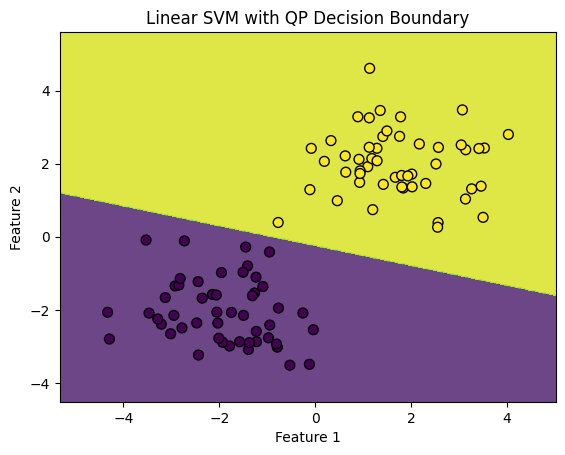

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# Generate a simple linearly separable dataset
def generate_linear_separable_data():
    # Class 1
    X1 = np.random.randn(50, 2) + np.array([2, 2])
    y1 = np.ones(50)

    # Class -1
    X2 = np.random.randn(50, 2) + np.array([-2, -2])
    y2 = -np.ones(50)

    # Combine the two classes
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))
    return X, y

# Visualization function for SVM decision boundary
def plot_decision_boundary(X, y, model, title="Decision Boundary"):
    # Create grid to evaluate model
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict on the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour and training points
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Generate data
X_train, y_train = generate_linear_separable_data()
X_test, y_test = generate_linear_separable_data()

""" # Test Linear SVM with Stochastic Gradient Descent (SGD)
print("Testing Linear SVM with SGD")
linear_svm_gd = LinearSVM_GD(learning_rate=0.01, n_epochs=100, batch_size=16, C=1.0)
linear_svm_gd.fit(X_train, y_train)
y_pred_linear = linear_svm_gd.predict(X_test)
accuracy_linear = np.mean(y_pred_linear == y_test)
print("Linear SVM GD Test Accuracy:", accuracy_linear)

# Visualize Linear SVM SGD decision boundary
plot_decision_boundary(X_train, y_train, linear_svm_gd, title="Linear SVM with SGD Decision Boundary") """

# Test Hard-margin SVM with Quadratic Programming (QP)
print("\nTesting Linear SVM with QP")
linear_svm_qp = LinearSVM_QP()
linear_svm_qp.fit(X_train, y_train)
y_pred_hard_margin = linear_svm_qp.predict(X_test)
accuracy_hard_margin = np.mean(y_pred_hard_margin == y_test)
print("Linear SVM QP Test Accuracy:", accuracy_hard_margin)

# Visualize Hard-margin SVM QP decision boundary
plot_decision_boundary(X_train, y_train, linear_svm_qp, title="Linear SVM with QP Decision Boundary")
